# Autoencoder IDS (Paper-aligned) + Threshold Calibration

This notebook implements an **Autoencoder (AE)** anomaly detector aligned with the referenced paper:

- Train AE on **normal** traffic only
- Use **reconstruction error (MSE)** as anomaly score
- Paper baseline threshold: `mean(RE_normal) + std(RE_normal)`
- Production calibration: threshold tuning + balanced evaluation + saved `final_threshold`

Artifacts: AE (.keras), SavedModel export, optional TFLite quantization, and threshold CSV/JSON files.


In [1]:
import os, sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Tuple, List, Dict, Any

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay,
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

sys.path.append("../src")
from common_utils import print_section, load_csv, ensure_dir, save_json

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [2]:
@dataclass
class AEConfig:
    raw_path: str = "../data/raw/RT_IOT2022"   # raw dataset with Attack_type
    target_col: str = "Attack_type"
    categorical_cols: Tuple[str, ...] = ("proto", "service")

    # Normal classes (must match raw labels exactly)
    normal_classes: Tuple[str, ...] = ("Thing_Speak", "MQTT_Publish", "Wipro_bulb")

    latent_dim: int = 16
    hidden_dims: Tuple[int, ...] = (64, 32)
    dropout: float = 0.10
    lr: float = 1e-3
    batch_size: int = 512
    epochs: int = 50

    # Paper threshold k (baseline): mean + k*std
    k_paper: float = 1.0

    out_dir: str = "../artifacts_ae"
    model_name: str = "autoencoder_ids"

cfg = AEConfig()


In [3]:
# Load raw dataset
df_raw = load_csv(cfg.raw_path)

print_section("Raw Dataset Loaded")
print("Shape:", df_raw.shape)
print("Top labels:\n", df_raw[cfg.target_col].value_counts().head(20))



Raw Dataset Loaded
Shape: (123117, 85)
Top labels:
 Attack_type
DOS_SYN_Hping                 94659
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64


In [4]:
# Build anomaly labels: 0=normal, 1=anomaly
df_ae = df_raw.copy()
df_ae["is_normal"] = df_ae[cfg.target_col].isin(cfg.normal_classes).astype(int)
df_ae["is_anomaly"] = (1 - df_ae["is_normal"]).astype(int)

print_section("Normal/Anomaly Split")
print("Normal classes used:", cfg.normal_classes)
print(df_ae["is_anomaly"].value_counts())
print("Anomaly %:", round(df_ae["is_anomaly"].mean()*100, 3))



Normal/Anomaly Split
Normal classes used: ('Thing_Speak', 'MQTT_Publish', 'Wipro_bulb')
is_anomaly
1    110610
0     12507
Name: count, dtype: int64
Anomaly %: 89.841


In [5]:
# Split: keep mixed test set; train AE only on normals
df_train_all, df_test_all = train_test_split(
    df_ae, test_size=0.20, random_state=RANDOM_SEED, stratify=df_ae["is_anomaly"]
)

df_train_normal = df_train_all[df_train_all["is_anomaly"] == 0].copy()
df_tr_norm, df_va_norm = train_test_split(df_train_normal, test_size=0.20, random_state=RANDOM_SEED)

print_section("AE Split Sizes")
print("Train normal:", df_tr_norm.shape)
print("Val normal  :", df_va_norm.shape)
print("Test mixed  :", df_test_all.shape, "Anomaly%:", round(df_test_all["is_anomaly"].mean()*100, 3))



AE Split Sizes
Train normal: (8004, 87)
Val normal  : (2002, 87)
Test mixed  : (24624, 87) Anomaly%: 89.843


In [6]:
# Preprocessing: one-hot categoricals + standardize numeric
drop_cols = [cfg.target_col, "is_normal", "is_anomaly"]

def build_preprocessor(df: pd.DataFrame) -> ColumnTransformer:
    feature_cols = [c for c in df.columns if c not in drop_cols]
    cat_cols = [c for c in cfg.categorical_cols if c in feature_cols]
    num_cols = [c for c in feature_cols if c not in cat_cols]

    num_tf = Pipeline([("scaler", StandardScaler())])
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)
    cat_tf = Pipeline([("ohe", ohe)])

    return ColumnTransformer(
        transformers=[
            ("num", num_tf, num_cols),
            ("cat", cat_tf, cat_cols),
        ],
        remainder="drop"
    )

def transform_dense(pre: ColumnTransformer, X_train: pd.DataFrame, X_val: pd.DataFrame, X_test: pd.DataFrame):
    Xtr = pre.fit_transform(X_train)
    Xva = pre.transform(X_val)
    Xte = pre.transform(X_test)

    Xtr = Xtr.toarray() if hasattr(Xtr, "toarray") else np.asarray(Xtr)
    Xva = Xva.toarray() if hasattr(Xva, "toarray") else np.asarray(Xva)
    Xte = Xte.toarray() if hasattr(Xte, "toarray") else np.asarray(Xte)
    return Xtr, Xva, Xte

pre = build_preprocessor(df_tr_norm)

Xtr, Xva, Xte = transform_dense(
    pre,
    df_tr_norm.drop(columns=drop_cols),
    df_va_norm.drop(columns=drop_cols),
    df_test_all.drop(columns=drop_cols),
)

yte_anom = df_test_all["is_anomaly"].astype(int).values

print_section("Transformed Shapes")
print("Xtr:", Xtr.shape, "Xva:", Xva.shape, "Xte:", Xte.shape)



Transformed Shapes
Xtr: (8004, 93) Xva: (2002, 93) Xte: (24624, 93)


In [7]:
# Autoencoder model (from scratch)
def build_autoencoder(input_dim: int) -> keras.Model:
    inp = keras.Input(shape=(input_dim,))
    x = inp

    for h in cfg.hidden_dims:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(cfg.dropout)(x)

    z = layers.Dense(cfg.latent_dim, activation="relu", name="latent")(x)

    x = z
    for h in reversed(cfg.hidden_dims):
        x = layers.Dense(h, activation="relu")(x)

    out = layers.Dense(input_dim, activation="linear")(x)

    ae = keras.Model(inp, out)
    ae.compile(optimizer=keras.optimizers.Adam(learning_rate=cfg.lr), loss="mse")
    return ae

ae = build_autoencoder(Xtr.shape[1])
print_section("Autoencoder Summary")
ae.summary()



Autoencoder Summary


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 93)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 93)             │         6,045 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,325 (67.68 KB)

 Trainable params: 17,325 (67.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8029 - val_loss: 1.8241 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7407 - val_loss: 1.6842 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6304 - val_loss: 1.5190 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5088 - val_loss: 1.4388 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4412 - val_loss: 1.3235 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4129 - val_loss: 1.2304 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3830 - val_loss: 1.1564 - learning_rate: 0.0010
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3652 - val_loss: 1.0852 - learning_rate: 0.0010
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3309 - val_loss: 1.0155 - learning_rate: 0.0010
Epoch 10/50
16/16 ━━━━━━━━━

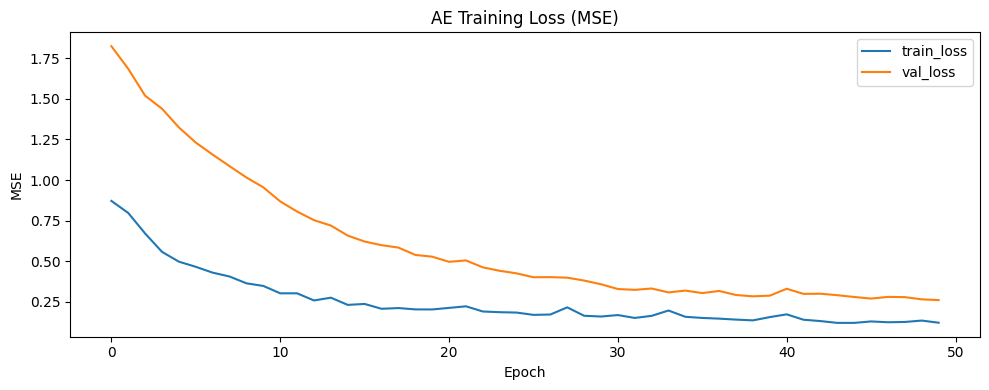

In [8]:
# Train AE on normal-only
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
]

hist = ae.fit(
    Xtr, Xtr,
    validation_data=(Xva, Xva),
    epochs=cfg.epochs,
    batch_size=cfg.batch_size,
    verbose=1,
    callbacks=callbacks
)

plt.figure(figsize=(10,4))
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.title("AE Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Reconstruction error + paper threshold baseline
def reconstruction_error(model: keras.Model, X: np.ndarray) -> np.ndarray:
    Xhat = model.predict(X, verbose=0)
    return np.mean((X - Xhat) ** 2, axis=1)

def threshold_mean_std(err_normal: np.ndarray, k: float = 1.0) -> float:
    return float(np.mean(err_normal) + k * np.std(err_normal))

err_val_norm = reconstruction_error(ae, Xva)
err_test = reconstruction_error(ae, Xte)

paper_threshold = threshold_mean_std(err_val_norm, k=cfg.k_paper)

print_section("Paper Threshold (mean + std)")
print("k:", cfg.k_paper)
print("threshold:", paper_threshold)



Paper Threshold (mean + std)
k: 1.0
threshold: 5.590849797801741



AE IDS Metrics (Paper Threshold)
accuracy : 0.8775584795321637
precision: 0.9996339295052818
recall   : 0.8640329069294399
f1       : 0.9269002303309493


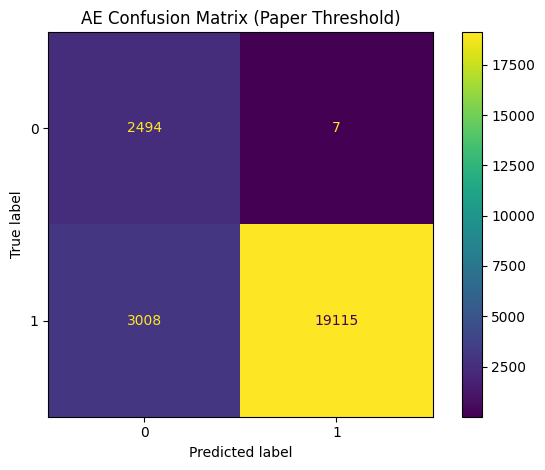

ROC-AUC (RE score): 0.9937517918746708
Avg Precision (RE score): 0.9992840883244678


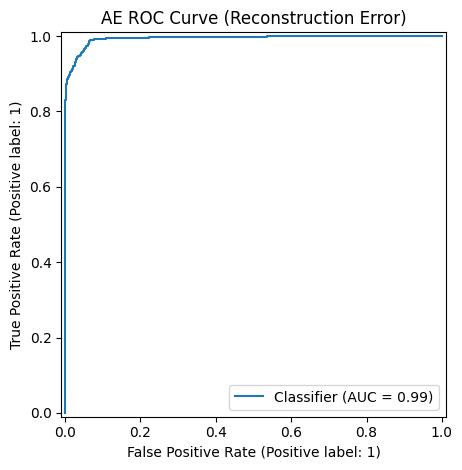

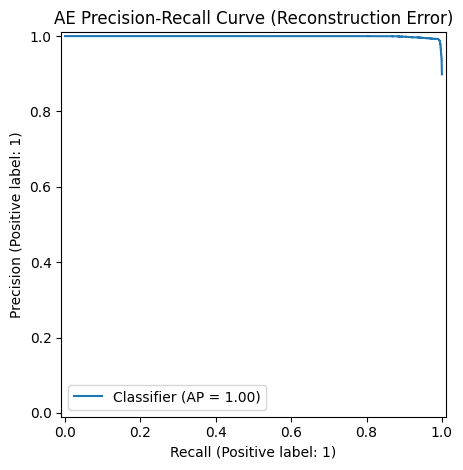

In [10]:
# Evaluate paper threshold on mixed test
y_pred_paper = (err_test > paper_threshold).astype(int)

acc = accuracy_score(yte_anom, y_pred_paper)
prec = precision_score(yte_anom, y_pred_paper, zero_division=0)
rec = recall_score(yte_anom, y_pred_paper, zero_division=0)
f1 = f1_score(yte_anom, y_pred_paper, zero_division=0)

print_section("AE IDS Metrics (Paper Threshold)")
print("accuracy :", acc)
print("precision:", prec)
print("recall   :", rec)
print("f1       :", f1)

cm = confusion_matrix(yte_anom, y_pred_paper)
ConfusionMatrixDisplay(cm).plot()
plt.title("AE Confusion Matrix (Paper Threshold)")
plt.tight_layout()
plt.show()

roc = roc_auc_score(yte_anom, err_test)
ap = average_precision_score(yte_anom, err_test)
print("ROC-AUC (RE score):", roc)
print("Avg Precision (RE score):", ap)

RocCurveDisplay.from_predictions(yte_anom, err_test)
plt.title("AE ROC Curve (Reconstruction Error)")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(yte_anom, err_test)
plt.title("AE Precision-Recall Curve (Reconstruction Error)")
plt.tight_layout()
plt.show()


## Threshold Calibration

We tune thresholds derived from the normal RE distribution and evaluate on both mixed and balanced test sets, then select a final operating point (production calibration).


In [11]:
# Threshold candidate generation + evaluation
def threshold_percentile(err_normal: np.ndarray, q: float) -> float:
    return float(np.percentile(err_normal, q))

def eval_threshold(y_true: np.ndarray, err: np.ndarray, thr: float) -> Dict[str, Any]:
    y_pred = (err > thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) else np.nan
    fnr = fn / (fn + tp) if (fn + tp) else np.nan
    return {
        "threshold": float(thr),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "fpr": float(fpr),
        "fnr": float(fnr),
        "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
    }

# Candidates from validation normal RE
k_list = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]
q_list = [90, 95, 97, 98, 99, 99.5]

candidates = []
for k in k_list:
    candidates.append({"method": "mean+std", "param": k, "threshold": threshold_mean_std(err_val_norm, k=k)})
for q in q_list:
    candidates.append({"method": "percentile", "param": q, "threshold": threshold_percentile(err_val_norm, q=q)})

thr_candidates = pd.DataFrame(candidates)

print_section("Threshold Candidates")
display(thr_candidates.sort_values(["method","param"]))



Threshold Candidates


,method,param,threshold
0,mean+std,0.25,1.593169
1,mean+std,0.50,2.925729
2,mean+std,0.75,4.258290
3,mean+std,1.00,5.590850
4,mean+std,1.25,6.923410
5,mean+std,1.50,8.255970
6,mean+std,2.00,10.921091
7,percentile,90.00,0.067669
8,percentile,95.00,0.249973
9,percentile,97.00,0.481240


In [12]:
# Evaluate on MIXED test
mixed_rows = []
for _, r in thr_candidates.iterrows():
    res = eval_threshold(yte_anom, err_test, float(r["threshold"]))
    mixed_rows.append({"method": r["method"], "param": float(r["param"]), **res})

mixed_tbl = pd.DataFrame(mixed_rows).sort_values("f1", ascending=False).reset_index(drop=True)

print_section("Threshold Results (MIXED TEST)")
display(mixed_tbl.head(15))



Threshold Results (MIXED TEST)


,method,param,threshold,accuracy,precision,recall,f1,fpr,fnr,tp,fp,tn,fn
0,percentile,90.00,0.067669,0.983715,0.989587,0.992316,0.990950,0.092363,0.007684,21953,231,2270,170
1,percentile,95.00,0.249973,0.957156,0.994600,0.957510,0.975703,0.045982,0.042490,21183,115,2386,940
2,percentile,97.00,0.481240,0.936322,0.996618,0.932288,0.963380,0.027989,0.067712,20625,70,2431,1498
3,percentile,98.00,0.707722,0.926048,0.997062,0.920400,0.957198,0.023990,0.079600,20362,60,2441,1761
4,mean+std,0.25,1.593169,0.906758,0.998491,0.897573,0.945346,0.011995,0.102427,19857,30,2471,2266
5,percentile,99.00,1.941684,0.901966,0.998785,0.891968,0.942359,0.009596,0.108032,19733,24,2477,2390
6,mean+std,0.50,2.925729,0.892828,0.999385,0.881255,0.936610,0.004798,0.118745,19496,12,2489,2627
7,percentile,99.50,3.893930,0.887183,0.999432,0.874927,0.933044,0.004398,0.125073,19356,11,2490,2767
8,mean+std,0.75,4.258290,0.884990,0.999534,0.872395,0.931647,0.003599,0.127605,19300,9,2492,2823
9,mean+std,1.00,5.590850,0.877558,0.999634,0.864033,0.926900,0.002799,0.135967,19115,7,2494,3008


In [13]:
# Build BALANCED test subset (50/50)
rng = np.random.default_rng(RANDOM_SEED)
idx0 = np.where(yte_anom == 0)[0]
idx1 = np.where(yte_anom == 1)[0]
n = min(len(idx0), len(idx1))

bal_idx = np.concatenate([rng.choice(idx0, n, replace=False), rng.choice(idx1, n, replace=False)])
rng.shuffle(bal_idx)

y_bal = yte_anom[bal_idx]
err_bal = err_test[bal_idx]

print_section("Balanced Test Subset")
print("Size:", len(bal_idx))
print("Counts:", {0: int((y_bal==0).sum()), 1: int((y_bal==1).sum())})



Balanced Test Subset
Size: 5002
Counts: {0: 2501, 1: 2501}


In [14]:
# Evaluate on BALANCED test
bal_rows = []
for _, r in thr_candidates.iterrows():
    res = eval_threshold(y_bal, err_bal, float(r["threshold"]))
    bal_rows.append({"method": r["method"], "param": float(r["param"]), **res})

bal_tbl = pd.DataFrame(bal_rows).sort_values("f1", ascending=False).reset_index(drop=True)

print_section("Threshold Results (BALANCED TEST)")
display(bal_tbl.head(15))



Threshold Results (BALANCED TEST)


,method,param,threshold,accuracy,precision,recall,f1,fpr,fnr,tp,fp,tn,fn
0,percentile,95.00,0.249973,0.956817,0.954274,0.959616,0.956938,0.045982,0.040384,2400,115,2386,101
1,percentile,90.00,0.067669,0.950220,0.914886,0.992803,0.952253,0.092363,0.007197,2483,231,2270,18
2,percentile,97.00,0.481240,0.951619,0.970821,0.931228,0.950612,0.027989,0.068772,2329,70,2431,172
3,percentile,98.00,0.707722,0.946821,0.974522,0.917633,0.945222,0.023990,0.082367,2295,60,2441,206
4,mean+std,0.25,1.593169,0.943423,0.986831,0.898840,0.940783,0.011995,0.101160,2248,30,2471,253
5,percentile,99.00,1.941684,0.943023,0.989399,0.895642,0.940189,0.009596,0.104358,2240,24,2477,261
6,mean+std,0.50,2.925729,0.939624,0.994602,0.884046,0.936071,0.004798,0.115954,2211,12,2489,290
7,percentile,99.50,3.893930,0.935226,0.994998,0.874850,0.931064,0.004398,0.125150,2188,11,2490,313
8,mean+std,0.75,4.258290,0.934226,0.995890,0.872051,0.929866,0.003599,0.127949,2181,9,2492,320
9,mean+std,1.00,5.590850,0.929628,0.996764,0.862055,0.924528,0.002799,0.137945,2156,7,2494,345


In [15]:
# Choose final threshold by policy:
# Policy 1 (recommended): Balanced Max-F1
best_row = bal_tbl.sort_values("f1", ascending=False).iloc[0]
final_threshold = float(best_row["threshold"])
final_policy = "balanced_max_f1"
final_choice = {"method": str(best_row["method"]), "param": float(best_row["param"])}

print_section("FINAL THRESHOLD SELECTED")
print("policy:", final_policy)
print("method:", final_choice["method"], "| param:", final_choice["param"])
print("final_threshold:", final_threshold)

# Final report (Mixed)
print("\nMIXED TEST @ final_threshold")
print(eval_threshold(yte_anom, err_test, final_threshold))

# Final report (Balanced)
print("\nBALANCED TEST @ final_threshold")
print(eval_threshold(y_bal, err_bal, final_threshold))



FINAL THRESHOLD SELECTED
policy: balanced_max_f1
method: percentile | param: 95.0
final_threshold: 0.2499734977387761

MIXED TEST @ final_threshold
{'threshold': 0.2499734977387761, 'accuracy': 0.9571556205328136, 'precision': 0.9946004319654428, 'recall': 0.95751028341545, 'f1': 0.9757030008521222, 'fpr': 0.045981607357057176, 'fnr': 0.042489716584550016, 'tp': 21183, 'fp': 115, 'tn': 2386, 'fn': 940}

BALANCED TEST @ final_threshold
{'threshold': 0.2499734977387761, 'accuracy': 0.9568172730907637, 'precision': 0.9542743538767395, 'recall': 0.9596161535385845, 'f1': 0.9569377990430622, 'fpr': 0.045981607357057176, 'fnr': 0.040383846461415435, 'tp': 2400, 'fp': 115, 'tn': 2386, 'fn': 101}


In [16]:
# Save threshold artifacts
ensure_dir(cfg.out_dir)

save_json(os.path.join(cfg.out_dir, "ae_threshold.json"), {
    "final_threshold": final_threshold,
    "final_policy": final_policy,
    "chosen_from": final_choice,
    "note": "Candidates derived from validation-normal RE. Final selected by max-F1 on balanced test."
})

mixed_tbl.to_csv(os.path.join(cfg.out_dir, "ae_threshold_tuning_mixed_test.csv"), index=False)
bal_tbl.to_csv(os.path.join(cfg.out_dir, "ae_threshold_tuning_balanced_test.csv"), index=False)

print_section("Saved Threshold Artifacts")
print(os.path.join(cfg.out_dir, "ae_threshold.json"))
print(os.path.join(cfg.out_dir, "ae_threshold_tuning_mixed_test.csv"))
print(os.path.join(cfg.out_dir, "ae_threshold_tuning_balanced_test.csv"))



Saved Threshold Artifacts
../artifacts_ae\ae_threshold.json
../artifacts_ae\ae_threshold_tuning_mixed_test.csv
../artifacts_ae\ae_threshold_tuning_balanced_test.csv


In [17]:
# Save AE model artifacts (Keras + SavedModel) and optional TFLite dynamic quantization
ensure_dir(cfg.out_dir)

keras_path = os.path.join(cfg.out_dir, f"{cfg.model_name}.keras")
ae.save(keras_path)

savedmodel_dir = os.path.join(cfg.out_dir, f"{cfg.model_name}_savedmodel")
ae.export(savedmodel_dir)

print_section("Saved AE Models")
print("Keras:", keras_path)
print("SavedModel:", savedmodel_dir)

# Optional: TFLite dynamic range quantization
converter = tf.lite.TFLiteConverter.from_saved_model(savedmodel_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_path = os.path.join(cfg.out_dir, f"{cfg.model_name}_dynamic.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print("TFLite (dynamic quant):", tflite_path)


INFO:tensorflow:Assets written to: ../artifacts_ae\autoencoder_ids_savedmodel\assets


INFO:tensorflow:Assets written to: ../artifacts_ae\autoencoder_ids_savedmodel\assets


Saved artifact at '../artifacts_ae\autoencoder_ids_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 93), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 93), dtype=tf.float32, name=None)
Captures:
  2165635106384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165635108688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165635109840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165635110416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165635109264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165635108496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165635111376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165635111760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165635107920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165635112720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2165635110800: T